In [1]:
import os
import networkx as nx
import datetime
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from nestedness_calculator import NestednessCalculator
import csv


In [2]:
def calc_nestedness(G):
    mat = nx.to_numpy_array(G, weight=None)
    mat = mat[~np.all(mat == 0, axis=1)]
    mat = mat[:,~np.all(mat == 0, axis=0)]
    nodf_score = NestednessCalculator(mat).nodf(mat)
    return nodf_score

In [3]:
#!pip install cugraph
# import cugraph as cnx

In [4]:
path = "graphs/nodes_hashtag/"
MANIFESTACION = "9n"
MAXCOMP = True
    

In [5]:
if MAXCOMP:
    file_maxcomp = "_maxcomp"
else:
    file_maxcomp =''

In [6]:
dict_file = {}
with open("data/files/" + MANIFESTACION + file_maxcomp + ".csv", "r") as file:
   reader = csv.DictReader(file)
   for row in reader:
       dict_file[row["hour"]] = row

In [7]:
direct = path + MANIFESTACION + '/'
arr_clust = []
arr_hour = []
arr_mod = []
arr_nest = []
print(direct)
with open("data/files/" + MANIFESTACION + file_maxcomp + ".csv", "a") as file:
   writer = csv.DictWriter(file, fieldnames=["hour", "nestedness", "modularity", "clusterization"])
   for root, dirs, files in os.walk(direct, topdown=False):
      for name in tqdm(files):
         if name.endswith(".gexf"):
               hora = name[:-5]
               arr_hour.append(hora)
               print("Analizando grafo", hora)
               if not hora in dict_file.keys():
                  G = nx.read_gexf(direct + name)
                  nestedness = calc_nestedness(G)
                  arr_nest.append(nestedness)
                  avg_clust=nx.average_clustering(G)
                  arr_clust.append(avg_clust)
                  modularity_louv = nx.community.modularity(G, nx.community.louvain_communities(G, seed=123))
                  arr_mod.append(modularity_louv)
                  writer.writerow({'hour': hora, 'nestedness': nestedness, 'clusterization': avg_clust, 'modularity': modularity_louv})
               #print("Analizado grafo", name[:-5], "coef_avg_clust:", round(avg_clust, 6), "coef_mod:", round(modularity_louv, 6))
               else:
                  print(hora, "ya está guardado")
                  arr_nest.append(float(dict_file[hora]["nestedness"]))
                  arr_clust.append(float(dict_file[hora]["clusterization"]))
                  arr_mod.append(float(dict_file[hora]["modularity"]))


graphs/nodes_hashtag/9n/


100%|██████████| 97/97 [00:00<00:00, 36902.27it/s]

Analizando grafo 436994
436994 ya está guardado
Analizando grafo 437016
437016 ya está guardado
Analizando grafo 437000
437000 ya está guardado
Analizando grafo 437070
437070 ya está guardado
Analizando grafo 437074
437074 ya está guardado
Analizando grafo 437022
437022 ya está guardado
Analizando grafo 437075
437075 ya está guardado
Analizando grafo 437069
437069 ya está guardado
Analizando grafo 436998
436998 ya está guardado
Analizando grafo 436987
436987 ya está guardado
Analizando grafo 437008
437008 ya está guardado
Analizando grafo 436988
436988 ya está guardado
Analizando grafo 437048
437048 ya está guardado
Analizando grafo 436996
436996 ya está guardado
Analizando grafo 436990
436990 ya está guardado
Analizando grafo 437058
437058 ya está guardado
Analizando grafo 436985
436985 ya está guardado
Analizando grafo 437059
437059 ya está guardado
Analizando grafo 437012
437012 ya está guardado
Analizando grafo 437002
437002 ya está guardado
Analizando grafo 437010
437010 ya está g

In [8]:
data = list(zip(arr_hour, arr_clust, arr_mod, arr_nest))
data.sort()
hour_sort, clust_sort, mod_sort, nest_sort = zip(*data)
hour_sort = list(hour_sort)
clust_sort = list(clust_sort)
mod_sort = list(mod_sort)
nest_sort = list(nest_sort)

In [9]:
dt_sort_arr=[]
for hour in hour_sort:
    dt_sort_arr.append(datetime.datetime.fromtimestamp(int(hour)*3600, tz=datetime.timezone.utc))
print(MANIFESTACION, ", hora con avg_clust max", dt_sort_arr[clust_sort.index(max(clust_sort))], "hour_name:", hour_sort[clust_sort.index(max(clust_sort))])
print(MANIFESTACION, ", hora con avg_clust min", dt_sort_arr[clust_sort.index(min(clust_sort))], "hour_name:", hour_sort[clust_sort.index(min(clust_sort))])

print(MANIFESTACION, ", hora con modularity max", dt_sort_arr[mod_sort.index(max(mod_sort))], "hour_name:", hour_sort[mod_sort.index(max(mod_sort))])
print(MANIFESTACION, ", hora con modularity min", dt_sort_arr[mod_sort.index(min(mod_sort))], "hour_name:", hour_sort[mod_sort.index(min(mod_sort))])

print(MANIFESTACION, ", hora con nestedness max", dt_sort_arr[nest_sort.index(max(nest_sort))], "hour_name:", hour_sort[nest_sort.index(max(nest_sort))])
print(MANIFESTACION, ", hora con nestedness min", dt_sort_arr[nest_sort.index(min(nest_sort))], "hour_name:", hour_sort[nest_sort.index(min(nest_sort))])

9n , hora con avg_clust max 2019-11-08 13:00:00+00:00 hour_name: 437005
9n , hora con avg_clust min 2019-11-07 15:00:00+00:00 hour_name: 436983
9n , hora con modularity max 2019-11-09 09:00:00+00:00 hour_name: 437025
9n , hora con modularity min 2019-11-07 15:00:00+00:00 hour_name: 436983
9n , hora con nestedness max 2019-11-11 05:00:00+00:00 hour_name: 437069
9n , hora con nestedness min 2019-11-07 15:00:00+00:00 hour_name: 436983


['436983', '436984', '436985', '436986', '436987', '436988', '436989', '436990', '436991', '436992', '436993', '436994', '436995', '436996', '436997', '436998', '436999', '437000', '437001', '437002', '437003', '437004', '437005', '437006', '437007', '437008', '437009', '437010', '437011', '437012', '437013', '437014', '437015', '437016', '437017', '437018', '437019', '437020', '437021', '437022', '437023', '437024', '437025', '437026', '437027', '437028', '437029', '437030', '437031', '437032', '437033', '437034', '437035', '437036', '437037', '437038', '437039', '437040', '437041', '437042', '437043', '437044', '437045', '437046', '437047', '437048', '437049', '437050', '437051', '437052', '437053', '437054', '437055', '437056', '437057', '437058', '437059', '437060', '437061', '437062', '437063', '437064', '437065', '437066', '437067', '437068', '437069', '437070', '437071', '437072', '437073', '437074', '437075', '437076', '437077', '437078', '437079']
2019-11-09 22:00:00+00:00
201

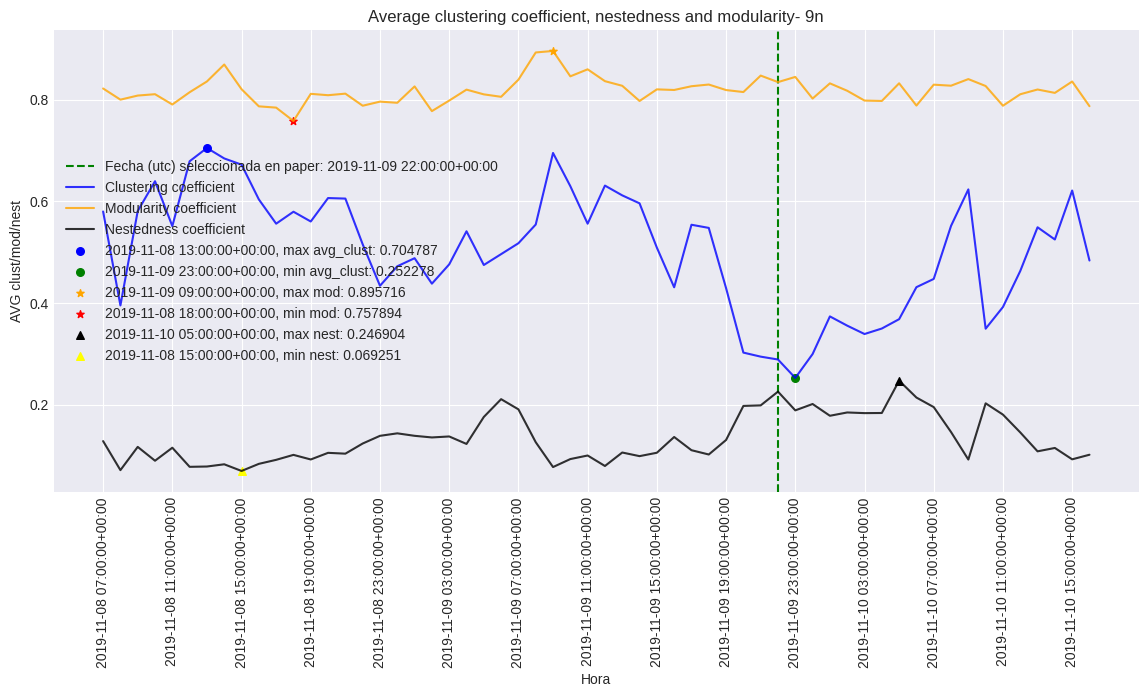

In [10]:
print(hour_sort)
if MANIFESTACION == "9n":
        #fecha=str(int(437037))
        fecha=str(int(437038))
        index_fecha=hour_sort.index(fecha)
        init=str(int(1573196400/3600))
        index_init=hour_sort.index(init)
        end=str(int(1573405200/3600))
        index_end=hour_sort.index(end)
else:
        fecha=str(int(429624))
        index_fecha=hour_sort.index(fecha)
        init=str(int(429531))
        index_init=hour_sort.index(init)
        end=str(int(1546902000/3600))
        index_end=hour_sort.index(end)
print(datetime.datetime.fromtimestamp(437038*3600, tz=datetime.timezone.utc))
print(datetime.datetime.fromtimestamp(437038*3600))
print("Fecha (utc) identificada en paper para", MANIFESTACION, datetime.datetime.fromtimestamp(int(fecha)*3600, tz=datetime.timezone.utc))
print("Fecha (utc) inicial en paper", dt_sort_arr[index_init], ", fecha final en paper", dt_sort_arr[index_end])
plt.figure(figsize=(14,6)) 
plt.style.use('seaborn-v0_8-darkgrid')    

plt.axvline(x=dt_sort_arr[index_fecha], color="green", ls="--", label="Fecha (utc) seleccionada en paper: " + str(datetime.datetime.fromtimestamp(int(fecha)*3600, tz=datetime.timezone.utc)))


plt.plot(dt_sort_arr[index_init:index_end], clust_sort[index_init:index_end], alpha=0.8, c="blue", label="Clustering coefficient")
plt.plot(dt_sort_arr[index_init:index_end], mod_sort[index_init:index_end], alpha=0.8, c="orange", label="Modularity coefficient")
plt.plot(dt_sort_arr[index_init:index_end], nest_sort[index_init:index_end], alpha=0.8, c="black", label="Nestedness coefficient")
#plt.scatter(dt_sort_arr, nest_sort)

name_max_clust = str(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(max(clust_sort[index_init:index_end]))]) + ", max avg_clust: " + str(round(max(clust_sort[index_init:index_end]), 6))
name_min_clust  = str(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(min(clust_sort[index_init:index_end]))]) + ", min avg_clust: " + str(round(min(clust_sort[index_init:index_end]), 6))
plt.scatter(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(max(clust_sort[index_init:index_end]))], max(clust_sort[index_init:index_end]), s=30, c="blue", marker="o", label = name_max_clust)
plt.scatter(dt_sort_arr[index_init:index_end][clust_sort[index_init:index_end].index(min(clust_sort[index_init:index_end]))], min(clust_sort[index_init:index_end]), s=30, c="green", marker="o", label = name_min_clust)

name_max_mod = str(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(max(mod_sort[index_init:index_end]))]) + ", max mod: " + str(round(max(mod_sort[index_init:index_end]), 6))
name_min_mod  = str(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(min(mod_sort[index_init:index_end]))]) + ", min mod: " + str(round(min(mod_sort[index_init:index_end]), 6))
plt.scatter(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(max(mod_sort[index_init:index_end]))], max(mod_sort[index_init:index_end]), s=30, c="orange", marker="*", label = name_max_mod)
plt.scatter(dt_sort_arr[index_init:index_end][mod_sort[index_init:index_end].index(min(mod_sort[index_init:index_end]))], min(mod_sort[index_init:index_end]), s=30, c="red", marker="*", label = name_min_mod)
#plt.plot(points[0], points[1], alpha=alpha, label="K_T = " + str(arr_kt_plot[index]))

name_max_nest = str(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(max(nest_sort[index_init:index_end]))]) + ", max nest: " + str(round(max(nest_sort[index_init:index_end]), 6))
name_min_nest  = str(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(min(nest_sort[index_init:index_end]))]) + ", min nest: " + str(round(min(nest_sort[index_init:index_end]), 6))
plt.scatter(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(max(nest_sort[index_init:index_end]))], max(nest_sort[index_init:index_end]), s=30, c="black", marker="^", label = name_max_nest)
plt.scatter(dt_sort_arr[index_init:index_end][nest_sort[index_init:index_end].index(min(nest_sort[index_init:index_end]))], min(nest_sort[index_init:index_end]), s=30, c="yellow", marker="^", label = name_min_nest)
   
plt.xlabel("Hora")
plt.ylabel("AVG clust/mod/nest")
plt.xticks(dt_sort_arr[index_init:index_end][::4], labels=dt_sort_arr[index_init:index_end][::4])
plt.xticks(rotation=90)
plt.title("Average clustering coefficient, nestedness and modularity- " + MANIFESTACION)
plt.legend()

plt.savefig("paper_avg_clust_mod_nest_" + MANIFESTACION + file_maxcomp, bbox_inches = "tight")

plt.show()


In [36]:
dt_sort_arr[index_init]

datetime.datetime(2019, 11, 8, 7, 0, tzinfo=datetime.timezone.utc)